<a href="https://colab.research.google.com/github/bintangfikrif/Unnamed-Final_Project/blob/main/notebooks/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Library

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
import os
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from scipy import stats
import warnings
warnings.filterwarnings('ignore')


plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_palette("viridis")

## Load Dataset
Disini kami menggabungkan 4 dataset


In [ ]:
# Load the datasets
try:
    df_remaining_forest = pd.read_csv("/content/spatial-metrics-indonesia-remaining_forest_kabupaten.csv")
    df_burned_area = pd.read_csv("/content/spatial-metrics-indonesia-burned_area_kabupaten.csv")
    df_deforestation = pd.read_csv("/content/spatial-metrics-indonesia-territorial_deforestation_kabupaten.csv")
    df_burned_peat = pd.read_csv("/content/spatial-metrics-indonesia-burned_peat_kabupaten.csv")
except FileNotFoundError as e:
    print(f"Error: Satu atau lebih file tidak ditemukan. Pastikan file berikut ada: {e}")
    raise

# --- 1. Filter by year (2015-2022) ---
start_year = 2015
end_year = 2022

df_remaining_forest_filtered = df_remaining_forest[
    (df_remaining_forest['year'] >= start_year) & (df_remaining_forest['year'] <= end_year)
].copy()

df_burned_area_filtered = df_burned_area[
    (df_burned_area['year'] >= start_year) & (df_burned_area['year'] <= end_year)
].copy()

df_deforestation_filtered = df_deforestation[
    (df_deforestation['year'] >= start_year) & (df_deforestation['year'] <= end_year)
].copy()

df_burned_peat_filtered = df_burned_peat[
    (df_burned_peat['year'] >= start_year) & (df_burned_peat['year'] <= end_year)
].copy()

# --- 2. Select specified columns ---
merge_key_columns = ['year', 'country', 'country_iso2', 'region', 'region_trase_id', 'parent_region', 'parent_region_trase_id']
df_burned_area_selected = df_burned_area_filtered[merge_key_columns + ['burned_areas_hectares']].copy()
df_deforestation_selected = df_deforestation_filtered[merge_key_columns + ['deforestation_hectares']].copy()
df_burned_peat_selected = df_burned_peat_filtered[merge_key_columns + ['fire_on_peatlands_hectares']].copy()

# --- 3. Merge the DataFrames ---
merged_df = df_remaining_forest_filtered.copy()
# Gabungkan dengan df_burned_area_selected
merged_df = pd.merge(merged_df, df_burned_area_selected, on=merge_key_columns, how='left')
# Gabungkan dengan df_deforestation_selected
merged_df = pd.merge(merged_df, df_deforestation_selected, on=merge_key_columns, how='left')
# Gabungkan dengan df_burned_peat_selected
merged_df = pd.merge(merged_df, df_burned_peat_selected, on=merge_key_columns, how='left')

# --- 4. Save the merged DataFrame to a new CSV file ---
output_filename = "combined_spatial_data_kabupaten_2015_2022.csv"
merged_df.to_csv(output_filename, index=False)

# Periksa rentang tahun di dataframe hasil gabungan
print(f"Berhasil menggabungkan dataframe dan menyimpannya ke '{output_filename}'")
print("\n--- Rentang tahun di DataFrame hasil gabungan ---")
print(f"Tahun Min: {merged_df['year'].min()}, Tahun Max: {merged_df['year'].max()}")

# Periksa nilai NaN di kolom-kolom yang baru ditambahkan
print("\n--- Jumlah NaN di kolom-kolom kunci hasil gabungan ---")
print(f"NaNs di burned_areas_hectares: {merged_df['burned_areas_hectares'].isna().sum()}")
print(f"NaNs di deforestation_hectares: {merged_df['deforestation_hectares'].isna().sum()}")
print(f"NaNs di fire_on_peatlands_hectares: {merged_df['fire_on_peatlands_hectares'].isna().sum()}")

Berhasil menggabungkan dataframe dan menyimpannya ke 'combined_spatial_data_kabupaten_2015_2022.csv'

--- Rentang tahun di DataFrame hasil gabungan ---
Tahun Min: 2015, Tahun Max: 2022

--- Jumlah NaN di kolom-kolom kunci hasil gabungan ---
NaNs di burned_areas_hectares: 0
NaNs di deforestation_hectares: 0
NaNs di fire_on_peatlands_hectares: 0


## Data Exploration

In [ ]:
COL_YEAR = 'year'                                    # Nama kolom untuk tahun
COL_REGION = 'region'                               # Nama kolom untuk Kabupaten/Kota
COL_FOREST_AREA = 'natural_forest_area_hectares'    # Nama kolom untuk luas hutan alam
COL_PROVINCE = 'parent_region'                      # Nama kolom untuk provinsi
COL_BURNED = 'burned_areas_hectares'                # Nama kolom untuk area terbakar
COL_DEFORESTATION = 'deforestation_hectares'        # Nama kolom untuk deforestasi
COL_FIRE_PEATLANDS = 'fire_on_peatlands_hectares'  # Nama kolom untuk kebakaran gambut

print("\n--- 1. Tinjauan Awal Data ---")
print(f"Memulai Analisis Data Eksploratif (EDA) untuk 'Prediksi Luas Hutan Alam Tersisa di Kabupaten/Kota di Indonesia (2015–2020)'")
print(f"• Periode: 2015-2022")
print(f"• Level: Kabupaten/Kota")
print(f"• Kolom kunci:")
print(f"  - Tahun: '{COL_YEAR}'")
print(f"  - Wilayah: '{COL_REGION}'")
print(f"  - Provinsi: '{COL_PROVINCE}'")
print(f"  - Luas Hutan: '{COL_FOREST_AREA}'")
print(f"  - Area Terbakar: '{COL_BURNED}'")
print(f"  - Deforestasi: '{COL_DEFORESTATION}'")
print(f"  - Kebakaran Gambut: '{COL_FIRE_PEATLANDS}'")

try:
    df = pd.read_csv('combined_spatial_data_kabupaten_2015_2022.csv')
    print(f"\n(a) Ukuran dataset: {df.shape[0]:,} baris x {df.shape[1]} kolom")
    print("\n(b) Menampilkan Info DataFrame")
    df.info()
    print("\n(c) Menampilkan 5 Baris Pertama")
    display(df.head())

except FileNotFoundError:
    print("File tidak ditemukan. Mencoba path alternatif...")
    try:
        df = pd.read_csv('/content/combined_spatial_data_kabupaten_2015_2022.csv')
        print(f"Data berhasil dimuat dari path alternatif!")
        print(f"• Ukuran dataset: {df.shape[0]:,} baris x {df.shape[1]} kolom")
    except Exception as e:
        print(f"Error memuat data: {e}")
        df = None



--- 1. Tinjauan Awal Data ---
Memulai Analisis Data Eksploratif (EDA) untuk 'Prediksi Luas Hutan Alam Tersisa di Kabupaten/Kota di Indonesia (2015–2020)'
• Periode: 2015-2022
• Level: Kabupaten/Kota
• Kolom kunci:
  - Tahun: 'year'
  - Wilayah: 'region'
  - Provinsi: 'parent_region'
  - Luas Hutan: 'natural_forest_area_hectares'
  - Area Terbakar: 'burned_areas_hectares'
  - Deforestasi: 'deforestation_hectares'
  - Kebakaran Gambut: 'fire_on_peatlands_hectares'

(a) Ukuran dataset: 3,912 baris x 11 kolom

(b) Menampilkan Info DataFrame
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3912 entries, 0 to 3911
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   year                          3912 non-null   int64  
 1   country                       3912 non-null   object 
 2   country_iso2                  3912 non-null   object 
 3   region                        3912 non-null   obj

,year,country,country_iso2,region,region_trase_id,parent_region,parent_region_trase_id,natural_forest_area_hectares,burned_areas_hectares,deforestation_hectares,fire_on_peatlands_hectares
0,2015,INDONESIA,ID,ACEH BARAT,ID-1107,ACEH,ID-11,193132.917177,501.840000,987.349059,346.140000
1,2015,INDONESIA,ID,ACEH BARAT DAYA,ID-1112,ACEH,ID-11,205857.455294,121.655294,660.441529,0.000000
2,2015,INDONESIA,ID,ACEH BESAR,ID-1108,ACEH,ID-11,249169.050353,0.000000,139.649647,0.000000
3,2015,INDONESIA,ID,ACEH JAYA,ID-1116,ACEH,ID-11,46943.872588,0.000000,166.788353,0.000000
4,2015,INDONESIA,ID,ACEH SELATAN,ID-1103,ACEH,ID-11,683659.868116,257.632588,1346.258471,257.632588


In [ ]:
if df is not None:
    # --- Pemeriksaan Tipe Data dan Konversi Potensial ---
    # Pastikan kolom kunci ada sebelum melanjutkan dengan EDA spesifik untuk mereka
    key_cols = [COL_YEAR, COL_REGION, COL_FOREST_AREA, COL_PROVINCE,
               COL_BURNED, COL_DEFORESTATION, COL_FIRE_PEATLANDS]
    missing_cols = [col for col in key_cols if col not in df.columns]

    if missing_cols:
        print(f"Kolom tidak ditemukan: {missing_cols}")
        print("Menghentikan EDA...")
    else:
        print(f"Semua kolom kunci ditemukan!")

    # Konversi tipe data
        print(f"\nKonversi tipe data")

        # Konversi tahun ke integer
        if df[COL_YEAR].dtype != 'int64':
            try:
                df[COL_YEAR] = pd.to_numeric(df[COL_YEAR], errors='coerce')
                print(f"'{COL_YEAR}' dikonversi ke numerik")
            except Exception as e:
                print(f"Error konversi {COL_YEAR}: {e}")

        # Konversi kolom numerik (luas hutan, deforestasi, dll)
        numeric_cols = [COL_FOREST_AREA, COL_BURNED, COL_DEFORESTATION, COL_FIRE_PEATLANDS]
        for col in numeric_cols:
            if not pd.api.types.is_numeric_dtype(df[col]):
                try:
                    # Hapus koma jika ada dan konversi ke numerik
                    df[col] = df[col].astype(str).str.replace(',', '', regex=False)
                    df[col] = pd.to_numeric(df[col], errors='coerce')
                    print(f"'{col}' dikonversi ke numerik")
                except Exception as e:
                    print(f"Error konversi {col}: {e}")

        # Konversi kolom kategorikal ke string
        categorical_cols = [COL_REGION, COL_PROVINCE]
        for col in categorical_cols:
            df[col] = df[col].astype(str)

        print(f"Konversi tipe data selesai!")

        # 2. Statistik Deskriptif
        print("\n--- 2. Statistik Deskriptif ---")
        print(f"\n(a) Statistik Kolom Numerik")
        numeric_summary = df.select_dtypes(include=np.number).describe(
            percentiles=[.01, .05, .25, .5, .75, .95, .99]
        )
        display(numeric_summary)

        print(f"\n(b) Statistik Kolom Kategorikal")

        # Statistik wilayah (kabupaten/kota)
        print(f"\nRingkasan Wilayah ('{COL_REGION}'):")
        print(f"• Jumlah kabupaten/kota unik: {df[COL_REGION].nunique():,}")
        print(f"• Total data points: {len(df):,}")

        # Statistik provinsi
        print(f"\nRingkasan Provinsi ('{COL_PROVINCE}'):")
        print(f"• Jumlah provinsi unik: {df[COL_PROVINCE].nunique()}")
        province_counts = df[COL_PROVINCE].value_counts().head(10)
        print(f"• 10 Provinsi dengan data terbanyak:")
        for prov, count in province_counts.items():
            print(f"  - {prov}: {count} data points")

        # Statistik tahun
        print(f"\nRingkasan Tahun ('{COL_YEAR}'):")
        year_counts = df[COL_YEAR].value_counts().sort_index()
        print(f"• Distribusi data per tahun:")
        for year, count in year_counts.items():
            print(f"  - {int(year)}: {count:,} data points")

        # 3. Nilai yang Hilang (Missing Values)
        print("\n--- 3. Nilai yang Hilang ---")
        missing_values = df.isnull().sum()
        missing_percentage = (missing_values / len(df)) * 100
        missing_df = pd.DataFrame({
                'Jumlah Missing': missing_values,
                    'Persentase Missing': missing_percentage
          })

        missing_summary = missing_df[missing_df['Jumlah Missing'] > 0]

        if len(missing_summary) > 0:
                print(f"⚠️  Ditemukan missing values:")
                display(missing_summary)

                # Heatmap missing values
                if missing_values.sum() > 0:
                    plt.figure(figsize=(12, 6))
                    sns.heatmap(df.isnull(), cbar=True, cmap='YlOrRd', yticklabels=False)
                    plt.title('Peta Missing Values dalam Dataset')
                    plt.xlabel('Kolom')
                    plt.tight_layout()
                    plt.show()
        else:
                    print(f"✅ Tidak ada missing values dalam dataset!")

        # 4. Baris Duplikat
        print("\n--- 4. Baris Duplikat ---")
        num_duplicates = df.duplicated().sum()
        print(f"Jumlah baris duplikat lengkap: {num_duplicates}")
        if num_duplicates > 0:
          display(df[df.duplicated(keep=False)].sort_values(by=[COL_REGION, COL_YEAR]))

Semua kolom kunci ditemukan!

Konversi tipe data
Konversi tipe data selesai!

--- 2. Statistik Deskriptif ---

(a) Statistik Kolom Numerik


,year,natural_forest_area_hectares,burned_areas_hectares,deforestation_hectares,fire_on_peatlands_hectares
count,3912.000000,3.912000e+03,3912.000000,3912.000000,3912.000000
mean,2018.500000,1.801828e+05,1693.745917,803.309257,409.273635
std,2.291581,4.437391e+05,12284.233835,3188.144647,4960.780710
min,2015.000000,0.000000e+00,0.000000,0.000000,0.000000
1%,2015.000000,0.000000e+00,0.000000,0.000000,0.000000
5%,2015.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,2016.750000,3.843282e+01,0.000000,0.000000,0.000000
50%,2018.500000,1.174043e+04,0.000000,22.397294,0.000000
75%,2020.250000,1.227989e+05,253.800000,485.559353,0.000000
95%,2022.000000,9.882630e+05,5646.333441,3609.405406,499.214171



(b) Statistik Kolom Kategorikal

Ringkasan Wilayah ('region'):
• Jumlah kabupaten/kota unik: 489
• Total data points: 3,912

Ringkasan Provinsi ('parent_region'):
• Jumlah provinsi unik: 34
• 10 Provinsi dengan data terbanyak:
  - JAWA TIMUR: 264 data points
  - SUMATERA UTARA: 256 data points
  - JAWA TENGAH: 248 data points
  - PAPUA: 224 data points
  - JAWA BARAT: 208 data points
  - ACEH: 184 data points
  - SULAWESI SELATAN: 184 data points
  - NUSA TENGGARA TIMUR: 176 data points
  - SULAWESI TENGGARA: 136 data points
  - SUMATERA SELATAN: 128 data points

Ringkasan Tahun ('year'):
• Distribusi data per tahun:
  - 2015: 489 data points
  - 2016: 489 data points
  - 2017: 489 data points
  - 2018: 489 data points
  - 2019: 489 data points
  - 2020: 489 data points
  - 2021: 489 data points
  - 2022: 489 data points

--- 3. Nilai yang Hilang ---
✅ Tidak ada missing values dalam dataset!

--- 4. Baris Duplikat ---
Jumlah baris duplikat lengkap: 0


(a) Distribusi Luas Hutan Alam:


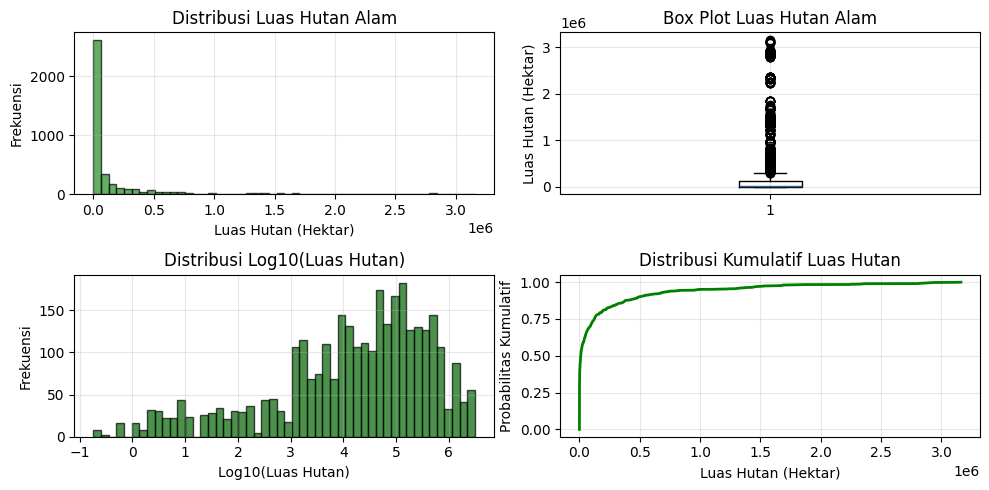


Statistik Luas Hutan Alam:
• Mean: 180,183 hektar
• Median: 11,740 hektar
• Std: 443,739 hektar
• Min: 0 hektar
• Max: 3,161,247 hektar
• Wilayah dengan hutan = 0: 696 (17.8%)

(b) Distribusi Variabel Lingkungan Lainnya:

Burned Areas Hectares:
  • Mean: 1,694 hektar
  • Median: 0 hektar
  • Nilai = 0: 2,027 (51.8%)

Deforestation Hectares:
  • Mean: 803 hektar
  • Median: 22 hektar
  • Nilai = 0: 1,356 (34.7%)

Fire On Peatlands Hectares:
  • Mean: 409 hektar
  • Median: 0 hektar
  • Nilai = 0: 3,450 (88.2%)


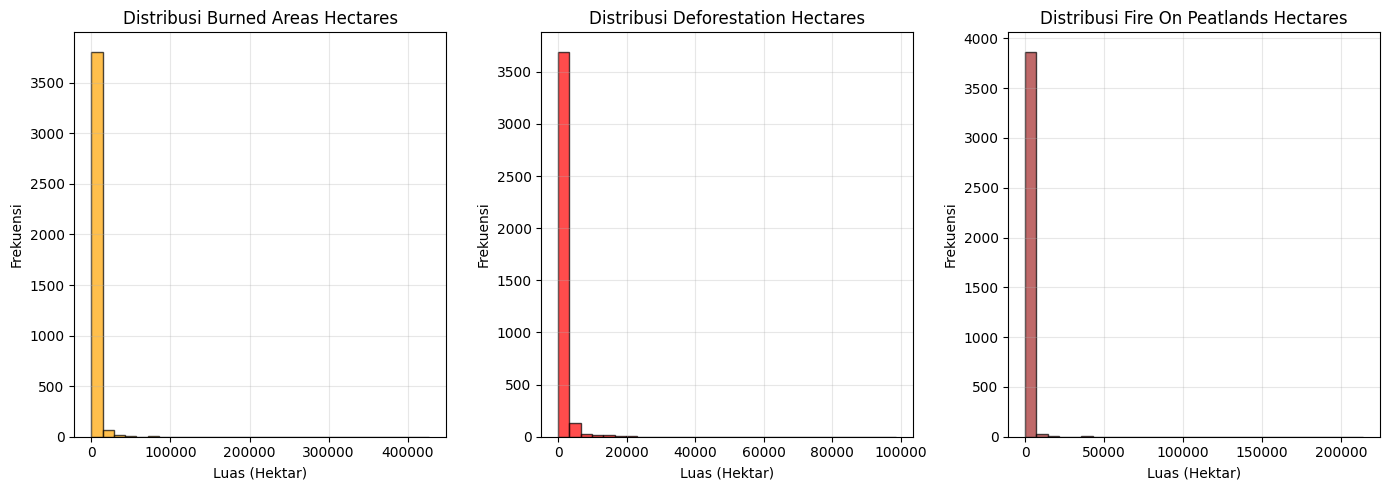

In [ ]:
        # Distribusi luas hutan
        print(f"(a) Distribusi Luas Hutan Alam:")

        fig, axes = plt.subplots(2, 2, figsize=(10, 5))

        # Histogram
        axes[0,0].hist(df[COL_FOREST_AREA], bins=50, alpha=0.7, color='forestgreen', edgecolor='black')
        axes[0,0].set_title('Distribusi Luas Hutan Alam')
        axes[0,0].set_xlabel('Luas Hutan (Hektar)')
        axes[0,0].set_ylabel('Frekuensi')
        axes[0,0].grid(True, alpha=0.3)

        # Box plot
        axes[0,1].boxplot(df[COL_FOREST_AREA].dropna(), vert=True)
        axes[0,1].set_title('Box Plot Luas Hutan Alam')
        axes[0,1].set_ylabel('Luas Hutan (Hektar)')
        axes[0,1].grid(True, alpha=0.3)

        # Log scale histogram (untuk handling skewness)
        forest_positive = df[df[COL_FOREST_AREA] > 0][COL_FOREST_AREA]
        if len(forest_positive) > 0:
            axes[1,0].hist(np.log10(forest_positive), bins=50, alpha=0.7, color='darkgreen', edgecolor='black')
            axes[1,0].set_title('Distribusi Log10(Luas Hutan)')
            axes[1,0].set_xlabel('Log10(Luas Hutan)')
            axes[1,0].set_ylabel('Frekuensi')
            axes[1,0].grid(True, alpha=0.3)

        # Cumulative distribution
        sorted_forest = np.sort(df[COL_FOREST_AREA].dropna())
        y_vals = np.arange(1, len(sorted_forest) + 1) / len(sorted_forest)
        axes[1,1].plot(sorted_forest, y_vals, color='green', linewidth=2)
        axes[1,1].set_title('Distribusi Kumulatif Luas Hutan')
        axes[1,1].set_xlabel('Luas Hutan (Hektar)')
        axes[1,1].set_ylabel('Probabilitas Kumulatif')
        axes[1,1].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        # Statistik luas hutan
        print(f"\nStatistik Luas Hutan Alam:")
        print(f"• Mean: {df[COL_FOREST_AREA].mean():,.0f} hektar")
        print(f"• Median: {df[COL_FOREST_AREA].median():,.0f} hektar")
        print(f"• Std: {df[COL_FOREST_AREA].std():,.0f} hektar")
        print(f"• Min: {df[COL_FOREST_AREA].min():,.0f} hektar")
        print(f"• Max: {df[COL_FOREST_AREA].max():,.0f} hektar")
        print(f"• Wilayah dengan hutan = 0: {(df[COL_FOREST_AREA] == 0).sum():,} ({((df[COL_FOREST_AREA] == 0).sum() / len(df) * 100):.1f}%)")

        # Distribusi variabel lainnya
        print(f"\n(b) Distribusi Variabel Lingkungan Lainnya:")

        env_vars = [COL_BURNED, COL_DEFORESTATION, COL_FIRE_PEATLANDS]
        fig, axes = plt.subplots(1, 3, figsize=(14, 5))

        for i, var in enumerate(env_vars):
            axes[i].hist(df[var], bins=30, alpha=0.7, color=['orange', 'red', 'brown'][i], edgecolor='black')
            axes[i].set_title(f'Distribusi {var.replace("_", " ").title()}')
            axes[i].set_xlabel('Luas (Hektar)')
            axes[i].set_ylabel('Frekuensi')
            axes[i].grid(True, alpha=0.3)

            # Statistik ringkas
            mean_val = df[var].mean()
            median_val = df[var].median()
            zero_count = (df[var] == 0).sum()
            zero_pct = (zero_count / len(df)) * 100

            print(f"\n{var.replace('_', ' ').title()}:")
            print(f"  • Mean: {mean_val:,.0f} hektar")
            print(f"  • Median: {median_val:,.0f} hektar")
            print(f"  • Nilai = 0: {zero_count:,} ({zero_pct:.1f}%)")

        plt.tight_layout()
        plt.show()


(a) Trend Nasional Luas Hutan per Tahun:


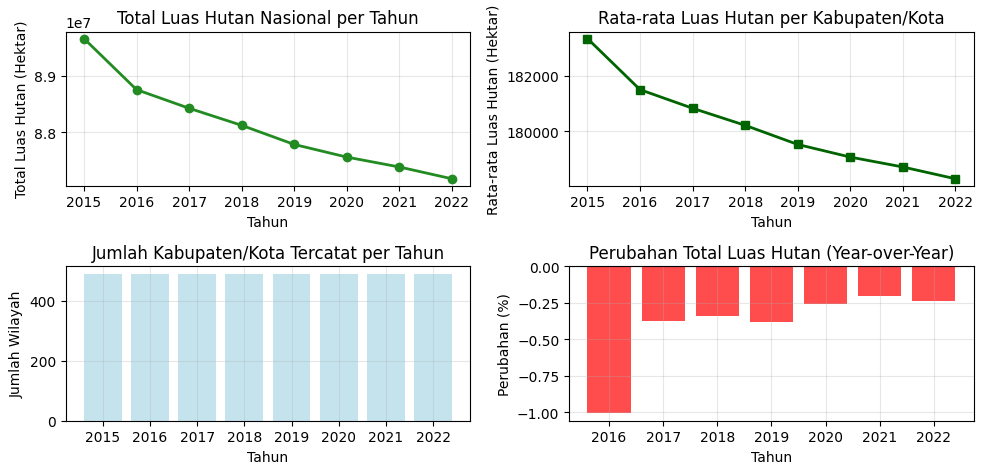


Ringkasan Trend Nasional:


,Tahun,Total_Hutan,Rata_rata_Hutan,Jumlah_Wilayah,Perubahan_Total
0,2015,8.965598e+07,183345.560427,489,NaN
1,2016,8.875378e+07,181500.575596,489,-1.006288
2,2017,8.842486e+07,180827.938997,489,-0.370598
3,2018,8.812358e+07,180211.820186,489,-0.340721
4,2019,8.778590e+07,179521.267456,489,-0.383189
5,2020,8.756283e+07,179065.087844,489,-0.254109
6,2021,8.738816e+07,178707.889907,489,-0.199479
7,2022,8.717993e+07,178282.058967,489,-0.238283



(b) Trend Provinsi (Top 5 berdasarkan luas hutan):


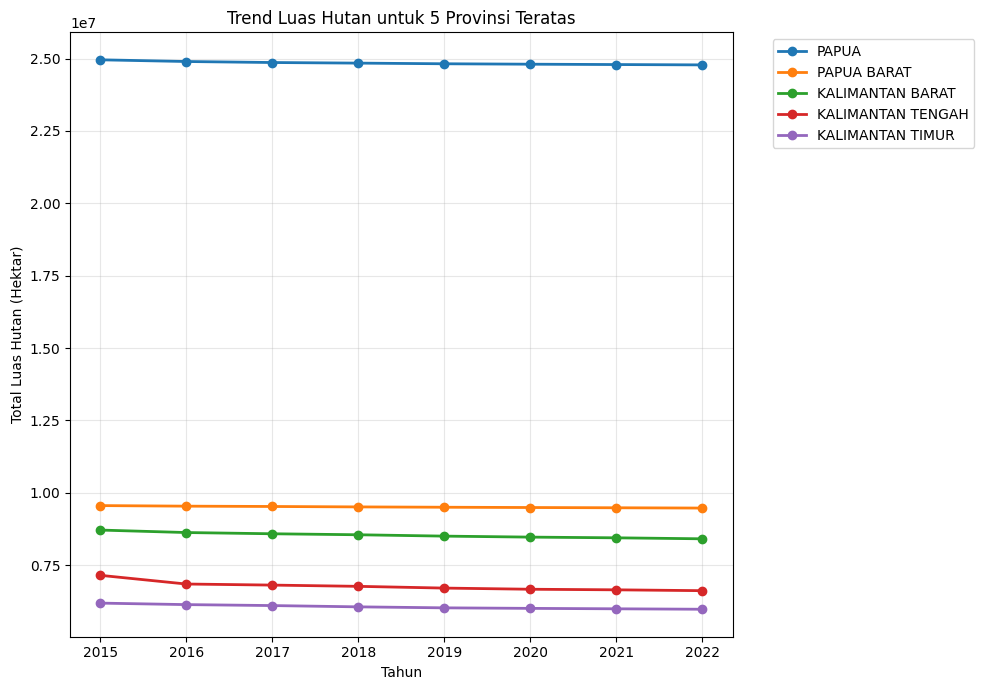

Provinsi yang dianalisis: PAPUA, PAPUA BARAT, KALIMANTAN BARAT, KALIMANTAN TENGAH, KALIMANTAN TIMUR

(a) Statistik Luas Hutan per Provinsi (Tahun Terbaru):
Data tahun 2022:


,Total,Rata_rata,Median,Std_Dev,Jumlah_Kab_Kota
parent_region,,,,,
PAPUA,24780805.0,885029.0,656623.0,887669.0,28
PAPUA BARAT,9473070.0,728698.0,615967.0,697377.0,13
KALIMANTAN BARAT,8411437.0,600817.0,125949.0,986693.0,14
KALIMANTAN TENGAH,6619954.0,472854.0,227274.0,576254.0,14
KALIMANTAN TIMUR,5978208.0,664245.0,261197.0,851840.0,9
SULAWESI TENGAH,5113628.0,393356.0,370245.0,392251.0,13
KALIMANTAN UTARA,3590511.0,718102.0,244186.0,1183841.0,5
ACEH,3355018.0,145870.0,45985.0,188078.0,23
MALUKU,2999291.0,272663.0,183916.0,312520.0,11



(b) Visualisasi Top 15 Provinsi (Total Luas Hutan):


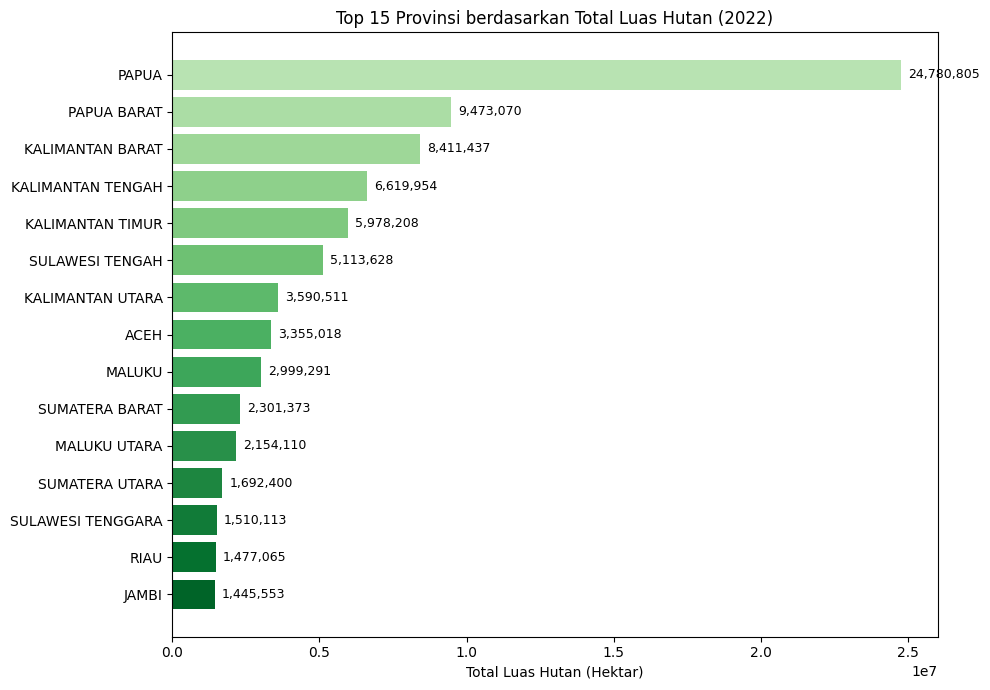

In [ ]:
    # Trend nasional per tahun
    print(f"\n(a) Trend Nasional Luas Hutan per Tahun:")

    yearly_stats = df.groupby(COL_YEAR)[COL_FOREST_AREA].agg(['sum', 'mean', 'count']).reset_index()
    yearly_stats.columns = ['Tahun', 'Total_Hutan', 'Rata_rata_Hutan', 'Jumlah_Wilayah']

    fig, axes = plt.subplots(2, 2, figsize=(10, 5))

    # Total luas hutan nasional
    axes[0,0].plot(yearly_stats['Tahun'], yearly_stats['Total_Hutan'], marker='o', linewidth=2, color='forestgreen')
    axes[0,0].set_title('Total Luas Hutan Nasional per Tahun')
    axes[0,0].set_xlabel('Tahun')
    axes[0,0].set_ylabel('Total Luas Hutan (Hektar)')
    axes[0,0].grid(True, alpha=0.3)

    # Rata-rata luas hutan per kabupaten
    axes[0,1].plot(yearly_stats['Tahun'], yearly_stats['Rata_rata_Hutan'], marker='s', linewidth=2, color='darkgreen')
    axes[0,1].set_title('Rata-rata Luas Hutan per Kabupaten/Kota')
    axes[0,1].set_xlabel('Tahun')
    axes[0,1].set_ylabel('Rata-rata Luas Hutan (Hektar)')
    axes[0,1].grid(True, alpha=0.3)

    # Jumlah wilayah yang tercatat per tahun
    axes[1,0].bar(yearly_stats['Tahun'], yearly_stats['Jumlah_Wilayah'], alpha=0.7, color='lightblue')
    axes[1,0].set_title('Jumlah Kabupaten/Kota Tercatat per Tahun')
    axes[1,0].set_xlabel('Tahun')
    axes[1,0].set_ylabel('Jumlah Wilayah')
    axes[1,0].grid(True, alpha=0.3)

    # Perubahan year-over-year
    yearly_stats['Perubahan_Total'] = yearly_stats['Total_Hutan'].pct_change() * 100
    axes[1,1].bar(yearly_stats['Tahun'][1:], yearly_stats['Perubahan_Total'][1:],
                  alpha=0.7, color=['red' if x < 0 else 'green' for x in yearly_stats['Perubahan_Total'][1:]])
    axes[1,1].set_title('Perubahan Total Luas Hutan (Year-over-Year)')
    axes[1,1].set_xlabel('Tahun')
    axes[1,1].set_ylabel('Perubahan (%)')
    axes[1,1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
    axes[1,1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print trend summary
    print(f"\nRingkasan Trend Nasional:")
    display(yearly_stats)

    # Trend sample provinsi
    print(f"\n(b) Trend Provinsi (Top 5 berdasarkan luas hutan):")

    # Pilih 5 provinsi dengan total luas hutan terbesar
    top_provinces = df.groupby(COL_PROVINCE)[COL_FOREST_AREA].sum().nlargest(5).index

    plt.figure(figsize=(10, 7))
    colors = sns.color_palette("tab10", len(top_provinces))

    for i, province in enumerate(top_provinces):
        prov_data = df[df[COL_PROVINCE] == province].groupby(COL_YEAR)[COL_FOREST_AREA].sum().reset_index()
        plt.plot(prov_data[COL_YEAR], prov_data[COL_FOREST_AREA],
                marker='o', linewidth=2, label=province, color=colors[i])

    plt.title('Trend Luas Hutan untuk 5 Provinsi Teratas')
    plt.xlabel('Tahun')
    plt.ylabel('Total Luas Hutan (Hektar)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    print(f"Provinsi yang dianalisis: {', '.join(top_provinces)}")

    print(f"\n(a) Statistik Luas Hutan per Provinsi (Tahun Terbaru):")

    latest_year = df[COL_YEAR].max()
    latest_data = df[df[COL_YEAR] == latest_year]

    province_stats = latest_data.groupby(COL_PROVINCE)[COL_FOREST_AREA].agg([
        'sum', 'mean', 'median', 'std', 'count'
    ]).round(0)
    province_stats.columns = ['Total', 'Rata_rata', 'Median', 'Std_Dev', 'Jumlah_Kab_Kota']
    province_stats = province_stats.sort_values('Total', ascending=False)

    print(f"Data tahun {int(latest_year)}:")
    display(province_stats.head(15))

    # Visualisasi provinsi
    print(f"\n(b) Visualisasi Top 15 Provinsi (Total Luas Hutan):")

    plt.figure(figsize=(10, 7))
    top_15_provinces = province_stats.head(15)

    bars = plt.barh(range(len(top_15_provinces)), top_15_provinces['Total'],
                    color=plt.cm.Greens(np.linspace(0.3, 0.9, len(top_15_provinces))))
    plt.yticks(range(len(top_15_provinces)), top_15_provinces.index)
    plt.xlabel('Total Luas Hutan (Hektar)')
    plt.title(f'Top 15 Provinsi berdasarkan Total Luas Hutan ({int(latest_year)})')
    plt.gca().invert_yaxis()

    # Add value labels
    for i, bar in enumerate(bars):
        width = bar.get_width()
        plt.text(width + max(top_15_provinces['Total']) * 0.01, bar.get_y() + bar.get_height()/2,
                f'{width:,.0f}', ha='left', va='center', fontsize=9)

    plt.tight_layout()
    plt.show()


Korelasi antar Variabel Lingkungan:


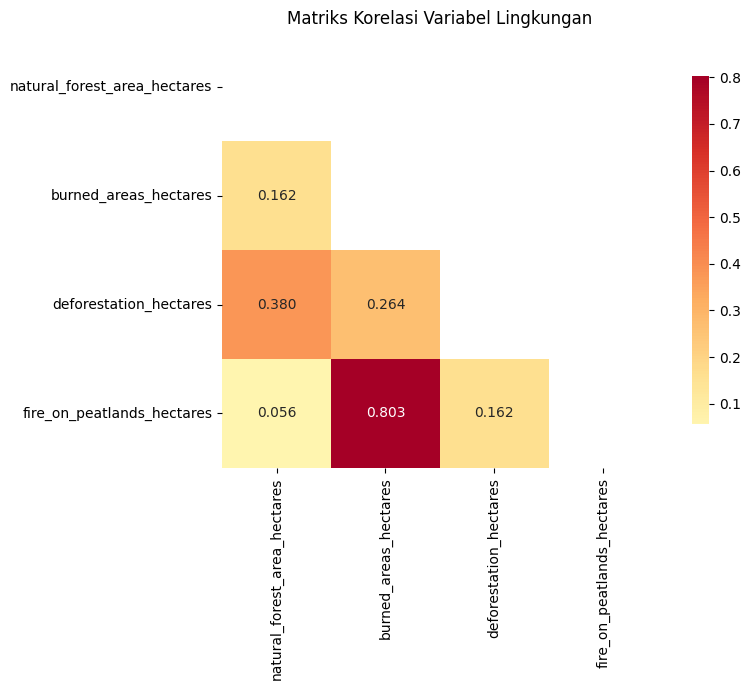


📊 Korelasi Signifikan (|r| > 0.3):
• natural_forest_area_hectares vs deforestation_hectares: r = 0.380
• burned_areas_hectares vs fire_on_peatlands_hectares: r = 0.803


In [ ]:
    # Korelasi antar variabel numerik
    print(f"\nKorelasi antar Variabel Lingkungan:")

    corr_vars = [COL_FOREST_AREA, COL_BURNED, COL_DEFORESTATION, COL_FIRE_PEATLANDS]
    correlation_matrix = df[corr_vars].corr()

    plt.figure(figsize=(9, 7))
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='RdYlBu_r',
                center=0, square=True, fmt='.3f', cbar_kws={"shrink": .8})
    plt.title('Matriks Korelasi Variabel Lingkungan')
    plt.tight_layout()
    plt.show()

    # Print korelasi yang signifikan
    print(f"\n📊 Korelasi Signifikan (|r| > 0.3):")
    for i in range(len(corr_vars)):
        for j in range(i+1, len(corr_vars)):
            corr_val = correlation_matrix.iloc[i, j]
            if abs(corr_val) > 0.3:
                print(f"• {corr_vars[i]} vs {corr_vars[j]}: r = {corr_val:.3f}")

Processed Deforestasi Teritorial: 489 regions
Processed Area Terbakar: 489 regions
Processed Area Gambut Terbakar: 489 regions
Processed Sisa Hutan Alam: 489 regions
Map saved to: peta_multi_csv_geojson_2022.png


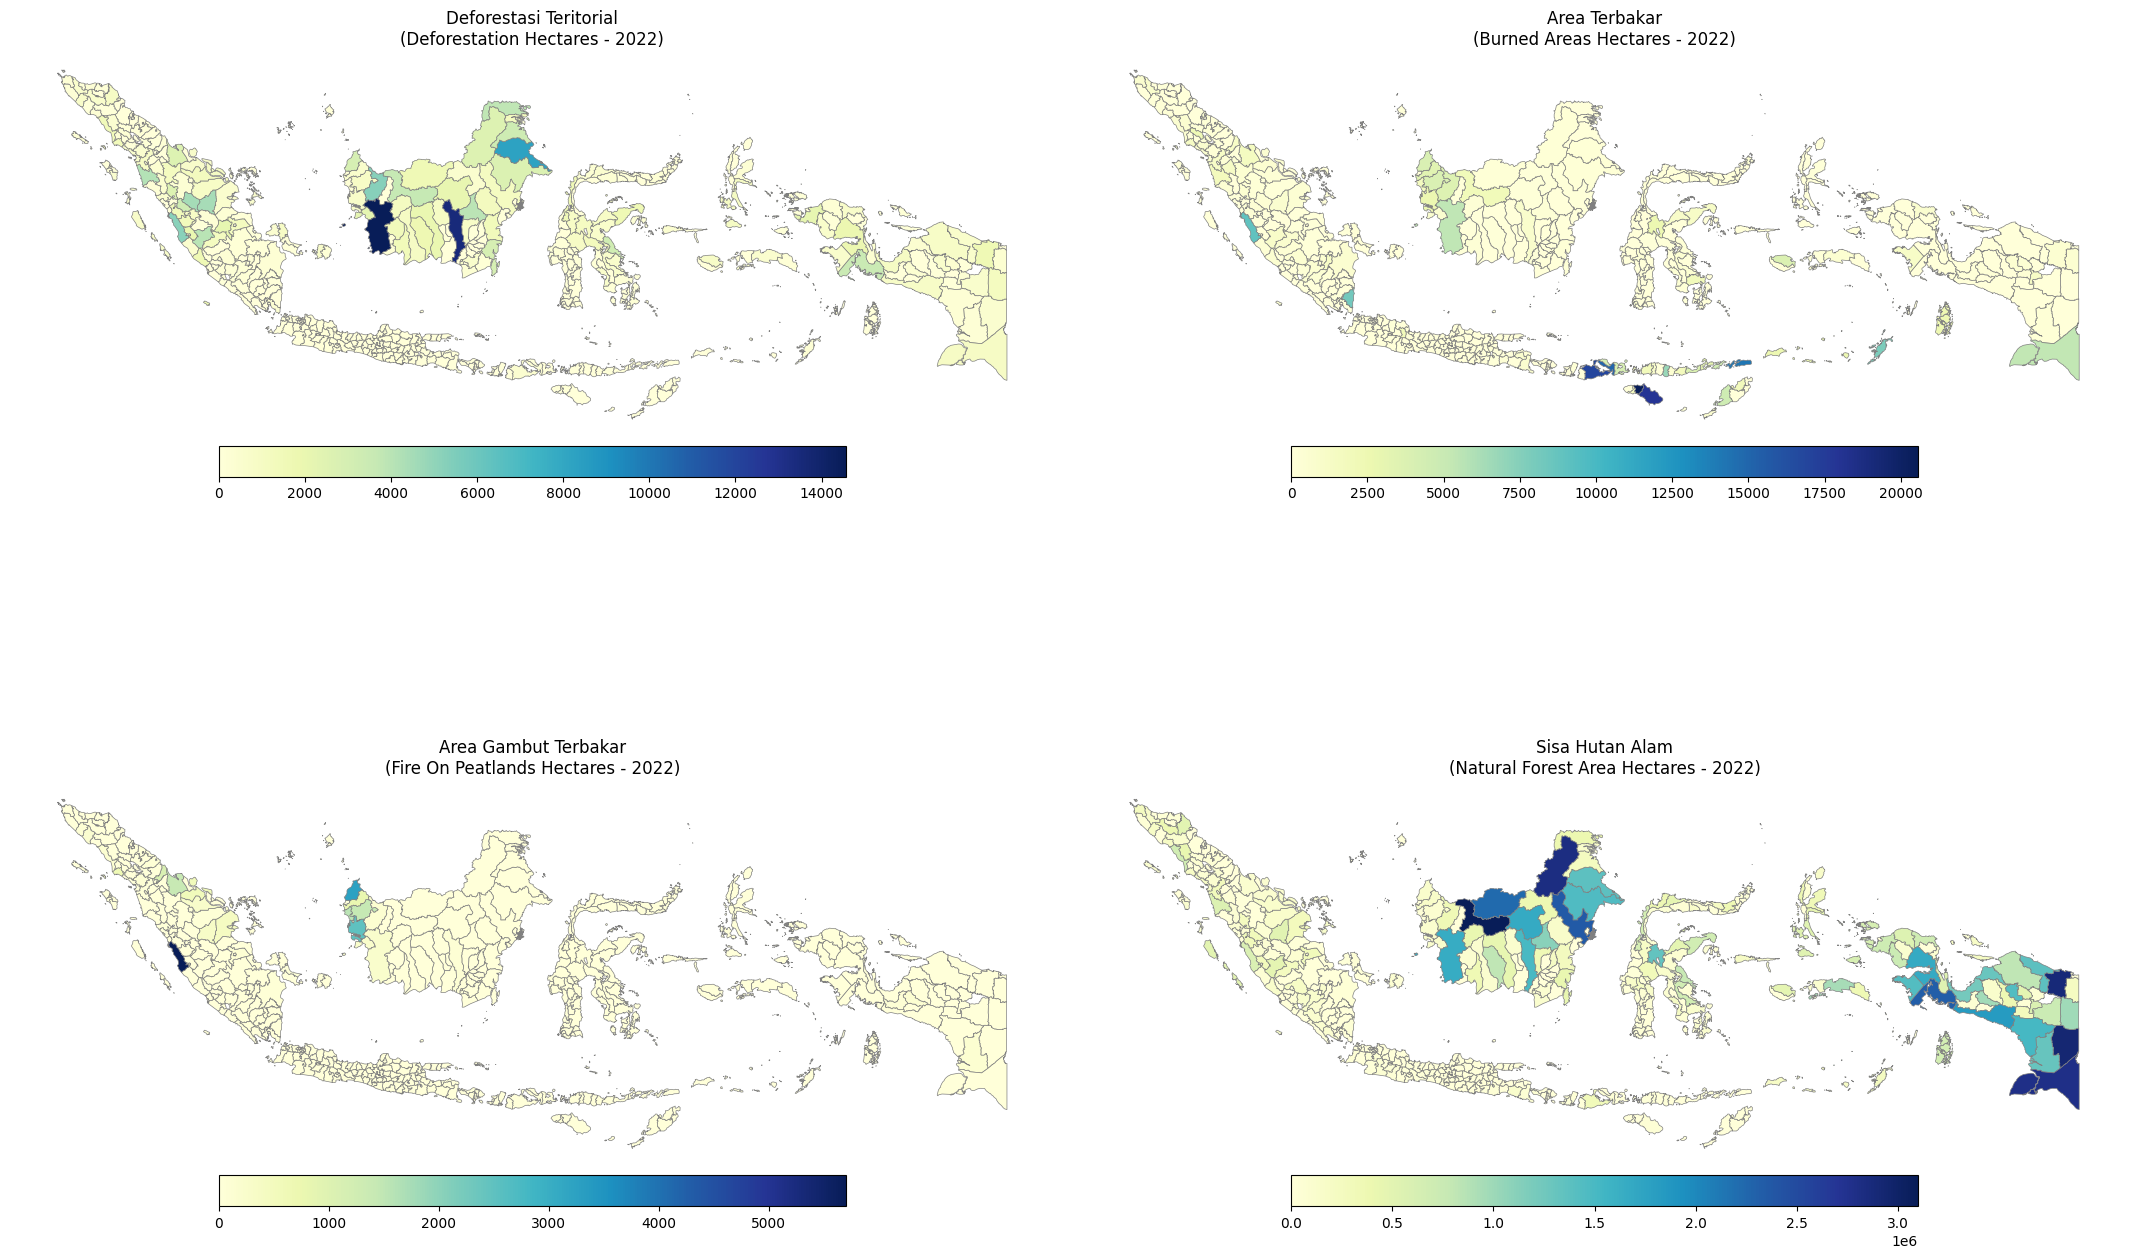

In [ ]:
# Configuration
YEAR = 2022
YEAR_COL = 'year'

# Data configuration
files_config = [
    {
        'geojson': 'spatial-metrics-indonesia-territorial_deforestation_kabupaten.geojson',
        'csv': 'spatial-metrics-indonesia-territorial_deforestation_kabupaten.csv',
        'value_col': 'deforestation_hectares',
        'title': 'Deforestasi Teritorial'
    },
    {
        'geojson': 'spatial-metrics-indonesia-burned_area_kabupaten.geojson',
        'csv': 'spatial-metrics-indonesia-burned_area_kabupaten.csv',
        'value_col': 'burned_areas_hectares',
        'title': 'Area Terbakar'
    },
    {
        'geojson': 'spatial-metrics-indonesia-burned_peat_kabupaten.geojson',
        'csv': 'spatial-metrics-indonesia-burned_peat_kabupaten.csv',
        'value_col': 'fire_on_peatlands_hectares',
        'title': 'Area Gambut Terbakar'
    },
    {
        'geojson': 'spatial-metrics-indonesia-remaining_forest_kabupaten.geojson',
        'csv': 'spatial-metrics-indonesia-remaining_forest_kabupaten.csv',
        'value_col': 'natural_forest_area_hectares',
        'title': 'Sisa Hutan Alam'
    }
]

# Create subplot
fig, axes = plt.subplots(2, 2, figsize=(22, 17))
axes = axes.flatten()

def process_subplot(config, ax, idx):
    try:
        # Load and process CSV
        df = pd.read_csv(config['csv'])

        # Filter by year and process
        df_year = df[df[YEAR_COL] == YEAR].copy() if YEAR_COL in df.columns else df.copy()

        if df_year.empty:
            ax.set_title(f"{config['title']}\nNo data for {YEAR}", color='red')
            ax.set_axis_off()
            return

        # Create PCODE match
        df_year['PCODE_match'] = df_year['region_trase_id'].astype(str).str.replace('ID-', '', regex=False)
        data_summary = df_year.groupby('PCODE_match')[config['value_col']].sum().reset_index()

        # Load GeoJSON
        gdf = gpd.read_file(config['geojson'])
        gdf['kabupaten_geocode'] = gdf['kabupaten_geocode'].astype(str)
        data_summary['PCODE_match'] = data_summary['PCODE_match'].astype(str)

        # Merge and plot
        merged_gdf = gdf.merge(data_summary, left_on='kabupaten_geocode', right_on='PCODE_match', how='left')
        merged_gdf[config['value_col']] = merged_gdf[config['value_col']].fillna(0)

        merged_gdf.plot(
            column=config['value_col'],
            ax=ax,
            legend=True,
            legend_kwds={'orientation': 'horizontal', 'shrink': 0.6, 'pad': 0.01},
            cmap='YlGnBu',
            edgecolor='gray',
            linewidth=0.5,
            missing_kwds={'color': 'lightgrey', 'hatch': '///', 'label': 'No Data'}
        )

        ax.set_title(f"{config['title']}\n({config['value_col'].replace('_', ' ').title()} - {YEAR})")
        ax.set_axis_off()

        print(f"Processed {config['title']}: {len(data_summary)} regions")

    except Exception as e:
        print(f"Error processing {config['title']}: {e}")
        ax.set_title(f"{config['title']}\nError: {str(e)[:30]}...", color='red')
        ax.set_axis_off()

# Process all subplots
for i, config in enumerate(files_config):
    process_subplot(config, axes[i], i)

# Save and display
plt.tight_layout(pad=3.0, h_pad=4.0, w_pad=2.0)
output_file = f"peta_multi_csv_geojson_{YEAR}.png"
plt.savefig(output_file)
print(f"Map saved to: {output_file}")
plt.show()

### Data Preproccessing

In [ ]:
try:
    df = pd.read_csv('combined_spatial_data_kabupaten_2015_2022.csv')
    print(f"Data berhasil dimuat")

except FileNotFoundError:
    print("Error: File combined_spatial_data_kabupaten_2015_2022.csv tidak ditemukan")
    print("Pastikan sudah menjalankan tahap merge data sebelumnya")
    exit()

# Define target column berdasarkan dataset
target_col = 'natural_forest_area_hectares'

def analyze_outliers(data, column):
    """Analisis outliers menggunakan IQR method"""
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]

    return {
        'Q1': Q1, 'Q3': Q3, 'IQR': IQR,
        'lower_bound': lower_bound, 'upper_bound': upper_bound,
        'outliers': outliers, 'outlier_count': len(outliers),
        'outlier_percentage': len(outliers) / len(data) * 100
    }
# Analisis outliers untuk target variable
outlier_analysis = analyze_outliers(df, target_col)

print(f"Outlier Analysis untuk {target_col}:")
print(f"  Q1: {outlier_analysis['Q1']:,.0f} hektar")
print(f"  Q3: {outlier_analysis['Q3']:,.0f} hektar")
print(f"  IQR: {outlier_analysis['IQR']:,.0f} hektar")
print(f"  Upper bound: {outlier_analysis['upper_bound']:,.0f} hektar")
print(f"  Outlier count: {outlier_analysis['outlier_count']:,} ({outlier_analysis['outlier_percentage']:.1f}%)")

# Check if there are any outliers before trying to display them
if outlier_analysis['outlier_count'] > 0:
    print(f"\nTop 10 Outliers (Luas Hutan Terbesar):")
    # Correctly access the 'outliers' DataFrame from the dictionary
    top_outliers = outlier_analysis['outliers'].nlargest(10, COL_FOREST_AREA)[[COL_REGION, COL_PROVINCE, COL_YEAR, COL_FOREST_AREA]]
    display(top_outliers)

# Identifikasi kabupaten dengan outliers konsisten
if outlier_analysis['outlier_count'] > 0:
    outlier_regions = outlier_analysis['outliers']['region'].value_counts().head(10)
    print(f"\nTop 10 Kabupaten dengan Outliers Terbanyak:")
    for region, count in outlier_regions.items():
        # Ensure division by zero is avoided
        total_region_data = df[df['region'] == region].shape[0]
        pct = (count / total_region_data) * 100 if total_region_data > 0 else 0
        print(f"  {region}: {count} kali ({pct:.0f}% dari data wilayah)")

Data berhasil dimuat
Outlier Analysis untuk natural_forest_area_hectares:
  Q1: 38 hektar
  Q3: 122,799 hektar
  IQR: 122,760 hektar
  Upper bound: 306,939 hektar
  Outlier count: 595 (15.2%)

Top 10 Outliers (Luas Hutan Terbesar):


,region,parent_region,year,natural_forest_area_hectares
411,SINTANG,KALIMANTAN BARAT,2015,3.161247e+06
900,SINTANG,KALIMANTAN BARAT,2016,3.142310e+06
1389,SINTANG,KALIMANTAN BARAT,2017,3.131554e+06
1878,SINTANG,KALIMANTAN BARAT,2018,3.122393e+06
2367,SINTANG,KALIMANTAN BARAT,2019,3.113644e+06
2856,SINTANG,KALIMANTAN BARAT,2020,3.106571e+06
3345,SINTANG,KALIMANTAN BARAT,2021,3.100550e+06
3834,SINTANG,KALIMANTAN BARAT,2022,3.096877e+06
86,BOVEN DIGOEL,PAPUA,2015,2.936107e+06
575,BOVEN DIGOEL,PAPUA,2016,2.930277e+06



Top 10 Kabupaten dengan Outliers Terbanyak:
  ACEH SELATAN: 8 kali (100% dari data wilayah)
  ACEH TENGAH: 8 kali (100% dari data wilayah)
  ACEH TENGGARA: 8 kali (100% dari data wilayah)
  ACEH TIMUR: 8 kali (100% dari data wilayah)
  ASMAT: 8 kali (100% dari data wilayah)
  BANGGAI: 8 kali (100% dari data wilayah)
  BARITO SELATAN: 8 kali (100% dari data wilayah)
  BARITO UTARA: 8 kali (100% dari data wilayah)
  BERAU: 8 kali (100% dari data wilayah)
  BOLAANG MONGONDOW: 8 kali (100% dari data wilayah)


Strategi: Log Transformation untuk menjaga integritas data pemerintah
Log-transformed features created:
  natural_forest_area_hectares -> forest_area_log
  burned_areas_hectares -> burned_areas_log
  deforestation_hectares -> deforestation_log
  fire_on_peatlands_hectares -> fire_peatlands_log


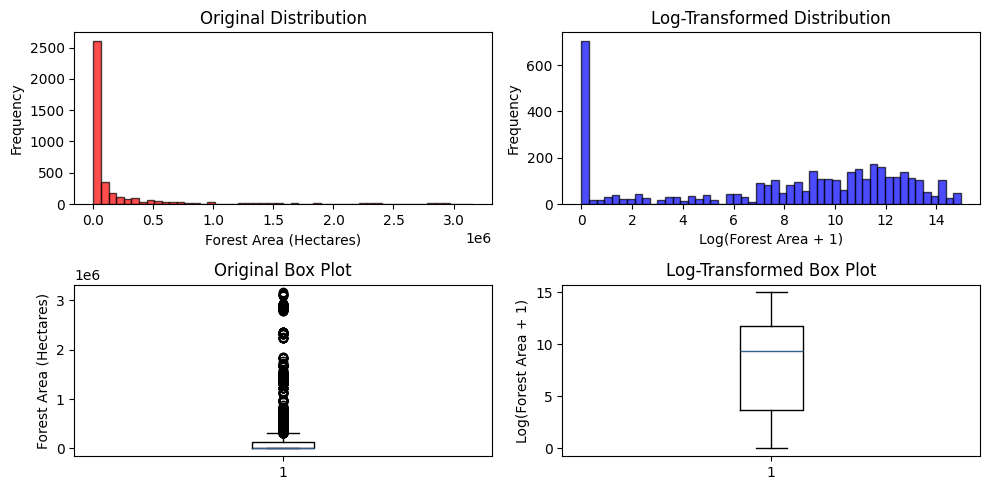


Skewness comparison:
  Original: 3.992
  Log-transformed: -0.560
  Improvement: +3.431

PERBANDINGAN OUTLIERS: ORIGINAL vs LOG

📊 Original Data:
  Total data: 3,912
  Outliers: 595 (15.2%)
  Q1: 38.43, Q3: 122798.85
  IQR: 122760.42
  Bounds: [-184102.19, 306939.48]

📊 Log-Transformed Data:
  Total data: 3,912
  Outliers: 0 (0.0%)
  Q1: 3.67, Q3: 11.72
  IQR: 8.04
  Bounds: [-8.39, 23.78]

Cleaned data saved to: forest_data_cleaned_stage2.csv
Cleaning report saved to: cleaning_report_stage2.json

Files generated:
  - forest_data_cleaned_stage2.csv (cleaned dataset)
  - cleaning_report_stage2.json (processing report)
  - outlier_transformation_comparison.png (visualization)


In [ ]:
# Strategy: Log transformation untuk mengurangi impact outliers tanpa menghilangkan data
print("Strategi: Log Transformation untuk menjaga integritas data pemerintah")

# Create log-transformed features
df['forest_area_log'] = np.log1p(df[target_col])  # log1p untuk handle zeros
df['burned_areas_log'] = np.log1p(df['burned_areas_hectares'])
df['deforestation_log'] = np.log1p(df['deforestation_hectares'])
df['fire_peatlands_log'] = np.log1p(df['fire_on_peatlands_hectares'])

print("Log-transformed features created:")
print(f"  {target_col} -> forest_area_log")
print(f"  burned_areas_hectares -> burned_areas_log")
print(f"  deforestation_hectares -> deforestation_log")
print(f"  fire_on_peatlands_hectares -> fire_peatlands_log")


# Compare distributions before and after log transformation
fig, axes = plt.subplots(2, 2, figsize=(10, 5))

# Original distribution
axes[0,0].hist(df[target_col], bins=50, alpha=0.7, color='red', edgecolor='black')
axes[0,0].set_title('Original Distribution')
axes[0,0].set_xlabel('Forest Area (Hectares)')
axes[0,0].set_ylabel('Frequency')

# Log-transformed distribution
axes[0,1].hist(df['forest_area_log'], bins=50, alpha=0.7, color='blue', edgecolor='black')
axes[0,1].set_title('Log-Transformed Distribution')
axes[0,1].set_xlabel('Log(Forest Area + 1)')
axes[0,1].set_ylabel('Frequency')

# Box plots
axes[1,0].boxplot(df[target_col])
axes[1,0].set_title('Original Box Plot')
axes[1,0].set_ylabel('Forest Area (Hectares)')

axes[1,1].boxplot(df['forest_area_log'])
axes[1,1].set_title('Log-Transformed Box Plot')
axes[1,1].set_ylabel('Log(Forest Area + 1)')

plt.tight_layout()
plt.savefig('outlier_transformation_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Calculate skewness improvement
original_skewness = stats.skew(df[target_col])
log_skewness = stats.skew(df['forest_area_log'])

print(f"\nSkewness comparison:")
print(f"  Original: {original_skewness:.3f}")
print(f"  Log-transformed: {log_skewness:.3f}")
print(f"  Improvement: {abs(original_skewness) - abs(log_skewness):+.3f}")

# Cek outliers
# Define the check_outliers_iqr function here or in a preceding cell
def check_outliers_iqr(data, column_name):
    # Remove NaN values
    clean_data = data.dropna()

    Q1 = clean_data.quantile(0.25)
    Q3 = clean_data.quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = clean_data[(clean_data < lower_bound) | (clean_data > upper_bound)]

    print(f"\n📊 {column_name}:")
    print(f"  Total data: {len(clean_data):,}")
    print(f"  Outliers: {len(outliers):,} ({len(outliers)/len(clean_data)*100:.1f}%)")
    print(f"  Q1: {Q1:.2f}, Q3: {Q3:.2f}")
    print(f"  IQR: {IQR:.2f}")
    print(f"  Bounds: [{lower_bound:.2f}, {upper_bound:.2f}]")

    return len(outliers)

print("\nPERBANDINGAN OUTLIERS: ORIGINAL vs LOG")

# Correct the function name from check_otliers_iqr to check_outliers_iqr
original_outliers = check_outliers_iqr(df[target_col], "Original Data")
log_outliers = check_outliers_iqr(df['forest_area_log'], "Log-Transformed Data")

# Save cleaned dataset
output_filename = 'forest_data_cleaned_stage2.csv'
df.to_csv(output_filename, index=False)
print(f"\nCleaned data saved to: {output_filename}")

# Save cleaning report
cleaning_report = {
    'original_shape': (df.shape[0], df.shape[1]),
    'period': f"{df['year'].min()}-{df['year'].max()}",
    'regions_count': df['region'].nunique(),
    'provinces_count': df['parent_region'].nunique(),
    'outlier_count': outlier_analysis['outlier_count'],
    'outlier_percentage': outlier_analysis['outlier_percentage'],
    'transformations_applied': [
        'log_transformation',
        'data_type_optimization',
        'regional_categorization',
        'negative_value_correction'
    ],
    'new_features': [
        'forest_area_log',
        'burned_areas_log',
        'deforestation_log',
        'fire_peatlands_log',
        'region_size_category'
    ]
}

import json
with open('cleaning_report_stage2.json', 'w') as f:
    json.dump(cleaning_report, f, indent=4)

print("Cleaning report saved to: cleaning_report_stage2.json")

print(f"\nFiles generated:")
print(f"  - {output_filename} (cleaned dataset)")
print(f"  - cleaning_report_stage2.json (processing report)")
print(f"  - outlier_transformation_comparison.png (visualization)")

**2. Isolasi dan Pengurutan Data Region**  
Filter DataFrame utama untuk mendapatkan semua data historis (2015-2022) hanya untuk region tersebut berdasarkan `region_trase_id`. Urutkan data region ini secara kronologis berdasarkan kolom year (dari tahun terkecil ke terbesar).

In [ ]:
# Group by region_trase_id and sort each group by year
grouped_and_sorted = df.groupby('region_trase_id').apply(lambda x: x.sort_values(by=COL_YEAR, ascending=True)).reset_index(drop=True)

print("Dataset sorted by year within each region_trase_id:")
display(grouped_and_sorted.head())

Dataset sorted by year within each region_trase_id:


,year,country,country_iso2,region,region_trase_id,parent_region,parent_region_trase_id,natural_forest_area_hectares,burned_areas_hectares,deforestation_hectares,fire_on_peatlands_hectares,forest_area_log,burned_areas_log,deforestation_log,fire_peatlands_log
0,2015,INDONESIA,ID,SIMEULUE,ID-1101,ACEH,ID-11,104868.869294,0.0,36.538941,0.0,11.560476,0.0,3.625379,0.0
1,2016,INDONESIA,ID,SIMEULUE,ID-1101,ACEH,ID-11,104699.221412,0.0,169.647882,0.0,11.558857,0.0,5.139602,0.0
2,2017,INDONESIA,ID,SIMEULUE,ID-1101,ACEH,ID-11,104574.212118,0.0,125.009294,0.0,11.557662,0.0,4.836356,0.0
3,2018,INDONESIA,ID,SIMEULUE,ID-1101,ACEH,ID-11,104497.082118,0.0,77.130000,0.0,11.556924,0.0,4.358374,0.0
4,2019,INDONESIA,ID,SIMEULUE,ID-1101,ACEH,ID-11,104413.112471,0.0,83.969647,0.0,11.556120,0.0,4.442294,0.0


**3. Cek Missing Value Setelah Merge Data**  
Dalam data per region yang sudah diisolasi dan diurutkan, periksa kembali kolom fitur dan target apakah ada nilai yang hilang (NaN).

In [ ]:
# Cek nilai yang hilang setelah semua pengolahan (terutama setelah merge)
print("\n--- Cek Missing Values Setelah Semua Pengolahan ---")
missing_values_final = df.isnull().sum()
missing_percentage_final = (missing_values_final / len(df)) * 100
missing_df_final = pd.DataFrame({
    'Jumlah Missing': missing_values_final,
    'Persentase Missing': missing_percentage_final
})

missing_summary_final = missing_df_final[missing_df_final['Jumlah Missing'] > 0]

if len(missing_summary_final) > 0:
    print(f"⚠️  Ditemukan missing values setelah pengolahan:")
    display(missing_summary_final)

    # Heatmap missing values final
    if missing_values_final.sum() > 0:
        plt.figure(figsize=(12, 6))
        sns.heatmap(df.isnull(), cbar=True, cmap='YlOrRd', yticklabels=False)
        plt.title('Peta Missing Values Akhir dalam Dataset')
        plt.xlabel('Kolom')
        plt.tight_layout()
        plt.show()
else:
    print(f"✅ Tidak ada missing values yang tersisa dalam dataset setelah pengolahan!")

# Cek data setelah sorting
print("\n--- Cek Data Setelah Sorting ---")
print("Menampilkan 10 baris pertama dari dataset yang sudah diurutkan:")
display(grouped_and_sorted.head(10))

print("\nMenampilkan 10 baris terakhir dari dataset yang sudah diurutkan:")
display(grouped_and_sorted.tail(10))

print("\nMemverifikasi urutan tahun untuk beberapa region_trase_id acak:")
sample_regions = grouped_and_sorted['region_trase_id'].sample(3).tolist()
for region in sample_regions:
    print(f"\nRegion: {region}")
    display(grouped_and_sorted[grouped_and_sorted['region_trase_id'] == region][[COL_YEAR, COL_REGION, COL_FOREST_AREA]])


--- Cek Missing Values Setelah Semua Pengolahan ---
✅ Tidak ada missing values yang tersisa dalam dataset setelah pengolahan!

--- Cek Data Setelah Sorting ---
Menampilkan 10 baris pertama dari dataset yang sudah diurutkan:


,year,country,country_iso2,region,region_trase_id,parent_region,parent_region_trase_id,natural_forest_area_hectares,burned_areas_hectares,deforestation_hectares,fire_on_peatlands_hectares,forest_area_log,burned_areas_log,deforestation_log,fire_peatlands_log
0,2015,INDONESIA,ID,SIMEULUE,ID-1101,ACEH,ID-11,104868.869294,0.000000,36.538941,0.000000,11.560476,0.000000,3.625379,0.000000
1,2016,INDONESIA,ID,SIMEULUE,ID-1101,ACEH,ID-11,104699.221412,0.000000,169.647882,0.000000,11.558857,0.000000,5.139602,0.000000
2,2017,INDONESIA,ID,SIMEULUE,ID-1101,ACEH,ID-11,104574.212118,0.000000,125.009294,0.000000,11.557662,0.000000,4.836356,0.000000
3,2018,INDONESIA,ID,SIMEULUE,ID-1101,ACEH,ID-11,104497.082118,0.000000,77.130000,0.000000,11.556924,0.000000,4.358374,0.000000
4,2019,INDONESIA,ID,SIMEULUE,ID-1101,ACEH,ID-11,104413.112471,0.000000,83.969647,0.000000,11.556120,0.000000,4.442294,0.000000
5,2020,INDONESIA,ID,SIMEULUE,ID-1101,ACEH,ID-11,104241.949765,113.310000,171.162706,0.000000,11.554480,4.738914,5.148440,0.000000
6,2021,INDONESIA,ID,SIMEULUE,ID-1101,ACEH,ID-11,104105.663647,0.000000,136.286118,0.000000,11.553171,0.000000,4.922067,0.000000
7,2022,INDONESIA,ID,SIMEULUE,ID-1101,ACEH,ID-11,103876.365882,0.000000,229.297765,0.000000,11.550966,0.000000,5.439373,0.000000
8,2015,INDONESIA,ID,ACEH SINGKIL,ID-1102,ACEH,ID-11,193812.976941,4.261765,2162.724706,4.261765,12.174654,1.660466,7.679586,1.660466
9,2016,INDONESIA,ID,ACEH SINGKIL,ID-1102,ACEH,ID-11,192572.529177,430.730824,1240.447765,128.790000,12.168233,6.067802,7.124034,4.865918



Menampilkan 10 baris terakhir dari dataset yang sudah diurutkan:


,year,country,country_iso2,region,region_trase_id,parent_region,parent_region_trase_id,natural_forest_area_hectares,burned_areas_hectares,deforestation_hectares,fire_on_peatlands_hectares,forest_area_log,burned_areas_log,deforestation_log,fire_peatlands_log
3902,2021,INDONESIA,ID,DEIYAI,ID-9436,PAPUA,ID-94,6453.031412,0.000000,30.230118,0.0,8.772460,0.000000,3.441383,0.0
3903,2022,INDONESIA,ID,DEIYAI,ID-9436,PAPUA,ID-94,6403.654941,0.000000,49.376471,0.0,8.764780,0.000000,3.919524,0.0
3904,2015,INDONESIA,ID,JAYAPURA (KOTA),ID-9471,PAPUA,ID-94,7256.508706,0.000000,42.807176,0.0,8.889792,0.000000,3.779798,0.0
3905,2016,INDONESIA,ID,JAYAPURA (KOTA),ID-9471,PAPUA,ID-94,7219.612235,0.000000,36.896471,0.0,8.884695,0.000000,3.634858,0.0
3906,2017,INDONESIA,ID,JAYAPURA (KOTA),ID-9471,PAPUA,ID-94,7201.234235,1.406471,18.378000,0.0,8.882147,0.878161,2.964138,0.0
3907,2018,INDONESIA,ID,JAYAPURA (KOTA),ID-9471,PAPUA,ID-94,7180.582235,0.000000,20.652000,0.0,8.879275,0.000000,3.075098,0.0
3908,2019,INDONESIA,ID,JAYAPURA (KOTA),ID-9471,PAPUA,ID-94,7161.435882,0.000000,19.146353,0.0,8.876605,0.000000,3.003023,0.0
3909,2020,INDONESIA,ID,JAYAPURA (KOTA),ID-9471,PAPUA,ID-94,7101.276706,41.408118,60.159176,0.0,8.868171,3.747340,4.113480,0.0
3910,2021,INDONESIA,ID,JAYAPURA (KOTA),ID-9471,PAPUA,ID-94,7065.450000,8.370000,35.826706,0.0,8.863114,2.237513,3.606223,0.0
3911,2022,INDONESIA,ID,JAYAPURA (KOTA),ID-9471,PAPUA,ID-94,7027.598118,0.000000,37.851882,0.0,8.857743,0.000000,3.659757,0.0



Memverifikasi urutan tahun untuk beberapa region_trase_id acak:

Region: ID-7207


,year,region,natural_forest_area_hectares
2944,2015,BUOL,468876.646588
2945,2016,BUOL,467639.157883
2946,2017,BUOL,466420.774235
2947,2018,BUOL,465649.251177
2948,2019,BUOL,464679.878118
2949,2020,BUOL,464182.251530
2950,2021,BUOL,463746.387177
2951,2022,BUOL,463252.820471



Region: ID-1811


,year,region,natural_forest_area_hectares
1032,2015,MESUJI,0.0
1033,2016,MESUJI,0.0
1034,2017,MESUJI,0.0
1035,2018,MESUJI,0.0
1036,2019,MESUJI,0.0
1037,2020,MESUJI,0.0
1038,2021,MESUJI,0.0
1039,2022,MESUJI,0.0



Region: ID-5311


,year,region,natural_forest_area_hectares
2256,2015,ENDE,9990.044824
2257,2016,ENDE,9987.524824
2258,2017,ENDE,9978.704824
2259,2018,ENDE,9968.534824
2260,2019,ENDE,9957.374824
2261,2020,ENDE,9934.334824
2262,2021,ENDE,9920.564824
2263,2022,ENDE,9843.524824


**4. Pilih Fitur dan Target Eksplisit untuk Setiap Region**  
Definisikan secara jelas mana kolom yang akan menjadi fitur input (X) dan mana yang menjadi target output (y) untuk model LSTM region tersebut. `X_columns` = `['burned_areas_hectares', 'deforestation_hectares', 'fire_on_peatlands_hectares']` (bisa juga ditambah natural_forest_area_hectares yang di-lag jika menggunakan pendekatan autoregresif).
`Y_column` = `['natural_forest_area_hectares']`

In [ ]:
X_columns = ['burned_areas_hectares', 'deforestation_hectares', 'fire_on_peatlands_hectares', 'natural_forest_area_hectares']
y_column = ['natural_forest_area_hectares']

X = df[X_columns]
Y = df[y_column]

print("Input features (X) shape:", X.shape)
print("Output target (Y) shape:", Y.shape)

print("\nInput features (X) head:")
display(X.head())

print("\nOutput target (Y) head:")
display(Y.head())

Input features (X) shape: (3912, 4)
Output target (Y) shape: (3912, 1)

Input features (X) head:


,burned_areas_hectares,deforestation_hectares,fire_on_peatlands_hectares,natural_forest_area_hectares
0,501.840000,987.349059,346.140000,193132.917177
1,121.655294,660.441529,0.000000,205857.455294
2,0.000000,139.649647,0.000000,249169.050353
3,0.000000,166.788353,0.000000,46943.872588
4,257.632588,1346.258471,257.632588,683659.868116



Output target (Y) head:


,natural_forest_area_hectares
0,193132.917177
1,205857.455294
2,249169.050353
3,46943.872588
4,683659.868116


**5. Scaling Data per Region**  
Buat dua objek scaler: satu untuk semua fitur input (X) dan satu lagi untuk variabel target (Y). `MinMaxScaler(feature_range=(0, 1))` adalah pilihan umum yang baik untuk LSTM.
Lakukan fit_transform pada data fitur `(X_region_data)` dengan scaler fitur. Lakukan fit_transform pada data target `(Y_region_data)` dengan scaler target. Simpan kedua objek scaler yang sudah di-fit ini (region_trase_id sebagai kunci).

In [ ]:
# Separate data by region_trase_id
regional_data = grouped_and_sorted.groupby('region_trase_id')

# Initialize dictionaries to store scalers
X_scalers = {}
Y_scalers = {}

# Define the columns to scale
X_cols_to_scale = ['burned_areas_hectares', 'deforestation_hectares', 'fire_on_peatlands_hectares'] # Features
Y_col_to_scale = 'natural_forest_area_hectares' # Target

# Store scaled data
scaled_X_data = []
scaled_Y_data = []
scaled_region_ids = []
scaled_years = []

# Loop through each region
for region_trase_id, region_df in regional_data:
    # Ensure region_df is a DataFrame
    if not isinstance(region_df, pd.DataFrame):
        print(f"Skipping region {region_trase_id} as it's not a DataFrame.")
        continue

    # Initialize scalers for the current region
    x_scaler = MinMaxScaler(feature_range=(0, 1))
    y_scaler = MinMaxScaler(feature_range=(0, 1))

    # Select the features and target for the current region
    X_region_data = region_df[X_cols_to_scale].copy()
    Y_region_data = region_df[[Y_col_to_scale]].copy() # Use double brackets to keep it as a DataFrame

    # Fit and transform the data for the current region
    # Handle potential errors if data is not suitable for scaling
    try:
        X_scaled_region = x_scaler.fit_transform(X_region_data)
        Y_scaled_region = y_scaler.fit_transform(Y_region_data)

        # Store the fitted scalers
        X_scalers[region_trase_id] = x_scaler
        Y_scalers[region_trase_id] = y_scaler

        # Store the scaled data, keeping track of region_trase_id and year
        scaled_X_data.append(X_scaled_region)
        scaled_Y_data.append(Y_scaled_region)
        scaled_region_ids.extend([region_trase_id] * len(region_df))
        scaled_years.extend(region_df[COL_YEAR].tolist())

        # Optional: print confirmation for scaled regions
        # print(f"Scaled data for region: {region_trase_id}")

    except ValueError as e:
        print(f"Could not scale data for region {region_trase_id} due to error: {e}")
        print(f"Region data shape: {region_df.shape}")
        print(f"X_region_data shape: {X_region_data.shape}")
        print(f"Y_region_data shape: {Y_region_data.shape}")
    except Exception as e:
        print(f"An unexpected error occurred while scaling region {region_trase_id}: {e}")


print("\nScaling completed for all regions.")
print(f"Number of X scalers saved: {len(X_scalers)}")
print(f"Number of Y scalers saved: {len(Y_scalers)}")

# Optionally, you can reconstruct the scaled DataFrame
# Be cautious with large datasets
if scaled_X_data and scaled_Y_data:
    # Concatenate the arrays
    all_scaled_X = np.vstack(scaled_X_data)
    all_scaled_Y = np.vstack(scaled_Y_data)

    # Create a new DataFrame for scaled data
    scaled_df = pd.DataFrame(all_scaled_X, columns=[f'{col}_scaled' for col in X_cols_to_scale])
    scaled_df[f'{Y_col_to_scale}_scaled'] = all_scaled_Y

    # Add back region_trase_id and year for context
    scaled_df['region_trase_id'] = scaled_region_ids
    scaled_df['year'] = scaled_years

    # Re-sort the scaled_df to match the original grouped_and_sorted order if needed
    scaled_df = scaled_df.sort_values(by=['region_trase_id', 'year']).reset_index(drop=True)


    print("\nExample of scaled data:")
    display(scaled_df.head())
    print(f"Scaled DataFrame shape: {scaled_df.shape}")

else:
    print("\nNo data was successfully scaled.")




Scaling completed for all regions.
Number of X scalers saved: 489
Number of Y scalers saved: 489

Example of scaled data:


,burned_areas_hectares_scaled,deforestation_hectares_scaled,fire_on_peatlands_hectares_scaled,natural_forest_area_hectares_scaled,region_trase_id,year
0,0.0,0.000000,0.0,1.000000,ID-1101,2015
1,0.0,0.690547,0.0,0.829071,ID-1101,2016
2,0.0,0.458969,0.0,0.703117,ID-1101,2017
3,0.0,0.210580,0.0,0.625405,ID-1101,2018
4,0.0,0.246062,0.0,0.540801,ID-1101,2019


Scaled DataFrame shape: (3912, 6)


**6. Membuat Sekuens (Windowing) untuk Model LSTM**  
Ubah data fitur dan target yang sudah di-scale menjadi format sekuens. Tentukan panjang look_back (3 tahun data historis untuk memprediksi tahun ke-4). Buat fungsi yang mengambil data fitur berskala dan data target berskala, lalu menghasilkan:
`X_sequences`: Array 3D dan `Y_sequences`: Array 1D atau 2D.
Pastikan ada cukup data di region tersebut untuk look_back yang dipilih (jumlah tahun > look_back).

In [ ]:
def create_sequences(data, look_back=3):
    X, Y = [], []
    # Ensure the data is a numpy array before iterating
    data_values = data.values
    # The target column is assumed to be the last column in the input data for simplicity
    # Adjust slicing if your target is not the last column
    target_column_index = data_values.shape[1] - 1 # Assuming target is the last column

    for i in range(len(data_values) - look_back):
        # Take the sequence of 'look_back' data points as input (X)
        seq_x = data_values[i:(i + look_back), :]
        X.append(seq_x)
        # The target (Y) is the forest area at the next time step
        seq_y = data_values[i + look_back, target_column_index]
        Y.append(seq_y)

    return np.array(X), np.array(Y)

# Define the look_back period (2 years)
look_back = 2

# Initialize lists to store sequences from all regions
X_sequences = []
Y_sequences = []

# Group the scaled data by region
scaled_regional_data = scaled_df.groupby('region_trase_id')

# Iterate through each region's scaled data
for region_trase_id, region_scaled_df in scaled_regional_data:
    # Select only the scaled numeric columns for sequence creation
    # Make sure the target column is also included in this selection
    # Assuming all columns ending with '_scaled' are the relevant ones
    scaled_numeric_cols = [col for col in region_scaled_df.columns if col.endswith('_scaled')]
    region_scaled_values = region_scaled_df[scaled_numeric_cols].values

    # Check if the region has enough data points to create sequences
    if len(region_scaled_values) >= look_back + 1: # Need at least look_back input + 1 target
        X_region, Y_region = create_sequences(pd.DataFrame(region_scaled_values), look_back)
        X_sequences.append(X_region)
        Y_sequences.append(Y_region)
    else:
        print(f"Skipping region {region_trase_id}: Not enough data points ({len(region_scaled_values)}) for look_back {look_back}.")


# Concatenate sequences from all regions
X_sequences = np.concatenate(X_sequences, axis=0)
Y_sequences = np.concatenate(Y_sequences, axis=0)

print("\nSequences created:")
print("X_sequences shape (samples, look_back, features):", X_sequences.shape)
print("Y_sequences shape (samples,):", Y_sequences.shape)

print("\nExample X_sequences (first sample):")
print(X_sequences[0])

print("\nExample Y_sequences (first target):")
print(Y_sequences[0])

# Optional: Verify the first few sequences visually
print("\nVisual verification of first 3 sequences:")
for i in range(min(3, len(X_sequences))):
    print(f"\nSequence {i+1}:")
    print("Input (X):")
    print(X_sequences[i])
    print("Target (Y):")
Y_sequences[i]

print(f"\nTotal sequences created: {len(X_sequences)}")




Sequences created:
X_sequences shape (samples, look_back, features): (2934, 2, 4)
Y_sequences shape (samples,): (2934,)

Example X_sequences (first sample):
[[0.         0.         0.         1.        ]
 [0.         0.69054655 0.         0.82907073]]

Example Y_sequences (first target):
0.7031172155401322

Visual verification of first 3 sequences:

Sequence 1:
Input (X):
[[0.         0.         0.         1.        ]
 [0.         0.69054655 0.         0.82907073]]
Target (Y):

Sequence 2:
Input (X):
[[0.         0.69054655 0.         0.82907073]
 [0.         0.45896915 0.         0.70311722]]
Target (Y):

Sequence 3:
Input (X):
[[0.         0.45896915 0.         0.70311722]
 [0.         0.21057951 0.         0.62540464]]
Target (Y):

Total sequences created: 2934


**7. Penyusunan Output Preprocessing**  
Simpan semua hasil preprocessing (sekuens X, sekuens Y, dan scaler fitur & target) untuk setiap region dalam struktur data yang rapi. Sebuah dictionary besar di mana key adalah region_trase_id dan value-nya adalah dictionary lain yang berisi `'X_sequences'`, `'y_sequences'`, `'feature_scaler'`, `'target_scaler'` untuk region.

In [ ]:
regional_preprocessing_data = {}

# Re-group the original data by region_trase_id
regional_data_original = grouped_and_sorted.groupby('region_trase_id')

# Re-group the scaled data by region_trase_id
regional_data_scaled = scaled_df.groupby('region_trase_id')

# Define the columns used for scaling and sequence creation
X_cols_for_scaling = ['burned_areas_hectares', 'deforestation_hectares', 'fire_on_peatlands_hectares']
Y_col_for_scaling = 'natural_forest_area_hectares'
# Assumed columns used in create_sequences function based on scaled_df creation
scaled_numeric_cols_used_in_sequences = [f'{col}_scaled' for col in X_cols_for_scaling] + [f'{Y_col_for_scaling}_scaled']


# Iterate through each region that was successfully scaled and sequenced
# We use the keys from X_scalers (or Y_scalers) as they represent the regions that were processed
for region_trase_id in X_scalers.keys():
    # Retrieve the original and scaled dataframes for this region
    # Ensure the region exists in the scaled data before proceeding
    # Changed scaled_data to scaled_df
    if region_trase_id not in scaled_df.groupby('region_trase_id').groups:
        print(f"Scaled data not found for region {region_trase_id}. Skipping sequence creation.")
        continue

    # Get the scaled dataframe for the current region
    # Changed scaled_data_copy to scaled_df
    region_scaled_df = scaled_df[scaled_df['region_trase_id'] == region_trase_id].copy()

    # Select the relevant scaled columns for sequence creation
    # Make sure to include the target column in the data passed to create_sequences
    data_for_sequences = region_scaled_df[scaled_numeric_cols_used_in_sequences]

    # Check if the region has enough data points to create sequences
    if len(data_for_sequences) >= look_back + 1:
        X_region_sequences, Y_region_sequences = create_sequences(data_for_sequences, look_back)

        # Store the data for this region in the main dictionary
        regional_preprocessing_data[region_trase_id] = {
            'X_sequences': X_region_sequences,
            'Y_sequences': Y_region_sequences,
            'feature_scaler': X_scalers[region_trase_id], # Store the scaler fitted on the original features
            'target_scaler': Y_scalers[region_trase_id]    # Store the scaler fitted on the original target
        }
        # print(f"Processed sequences and scalers for region: {region_trase_id}")
        # print(f"  X_sequences shape: {X_region_sequences.shape}")
        # print(f"  Y_sequences shape: {Y_region_sequences.shape}")

    else:
        print(f"Skipping region {region_trase_id} for final storage: Not enough data points ({len(data_for_sequences)}) for look_back {look_back} to create sequences.")


print(f"\nFinished processing all regions. Stored data for {len(regional_preprocessing_data)} regions.")


Finished processing all regions. Stored data for 489 regions.


In [ ]:
# Initialize lists to collect sequences from all regions
all_X_train_sequences = []
all_y_train_sequences = []

# Iterate through the prepared regional data
for region_id, data in regional_preprocessing_data.items():
    # Check if sequences exist for the region
    if 'X_sequences' in data and 'Y_sequences' in data:
        all_X_train_sequences.append(data['X_sequences'])
        all_y_train_sequences.append(data['Y_sequences'])
    else:
        print(f"Warning: Sequences not found for region {region_id}. Skipping.")

# Concatenate the lists of arrays into single NumPy arrays for training
# Use np.vstack or np.concatenate depending on the array shapes.
# Since X_sequences are 3D and y_sequences are 1D/2D (samples,), np.concatenate is suitable.
if all_X_train_sequences and all_y_train_sequences:
    X_train = np.concatenate(all_X_train_sequences, axis=0)
    y_train = np.concatenate(all_y_train_sequences, axis=0)

    print("\n--- Training Data Prepared ---")
    print("X_train shape (samples, look_back, features):", X_train.shape)
    print("y_train shape (samples,):", y_train.shape) # y_train should be 1D or 2D (samples, 1)

    print("\nExample X_train (first sample):")
    print(X_train[0])

    print("\nExample y_train (first target):")
    print(y_train[0])

else:
    X_train = np.array([]) # Initialize as empty array if no data
    y_train = np.array([]) # Initialize as empty array if no data
    print("\n--- Training Data Preparation Failed ---")
    print("No sequences were available to concatenate.")
    print("X_train shape:", X_train.shape)
    print("y_train shape:", y_train.shape)




--- Training Data Prepared ---
X_train shape (samples, look_back, features): (2934, 2, 4)
y_train shape (samples,): (2934,)

Example X_train (first sample):
[[0.         0.         0.         1.        ]
 [0.         0.69054655 0.         0.82907073]]

Example y_train (first target):
0.7031172155401322


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Define the model
model = Sequential()
model.add(LSTM(units=16, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]))) # input_shape is (look_back, number_of_features)
model.add(Dropout(0.2))
model.add(Dense(units=1)) # Output layer with 1 unit for regression

# Compile the model (example compilation)
# You might want to choose a different optimizer and loss function based on your needs
# Common for regression: 'adam' or 'rmsprop' optimizer, 'mse' or 'mae' loss
model.compile(optimizer='adam', loss='mse')

# Print model summary
print("\n--- LSTM Model Architecture ---")
model.summary()


--- LSTM Model Architecture ---


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 16)             │         1,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,361 (5.32 KB)

 Trainable params: 1,361 (5.32 KB)

 Non-trainable params: 0 (0.00 B)


--- Starting Model Training ---
Total samples for training: 2,934
Epochs: 50
Batch Size: 5
Epoch 1/50
587/587 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0138
Epoch 2/50
587/587 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0113
Epoch 3/50
587/587 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0134
Epoch 4/50
587/587 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0138
Epoch 5/50
587/587 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0129
Epoch 6/50
587/587 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0157
Epoch 7/50
587/587 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0155
Epoch 8/50
587/587 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0127
Epoch 9/50
587/587 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0123
Epoch 10/50
587/587 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0117
Epoch 11/50
587/587 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0136
Epoch 12/50
587/587 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0144
Epoch 13/50
587/587 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0110
Epoch 14/50
587/587 ━━━━━━━━━━━━━

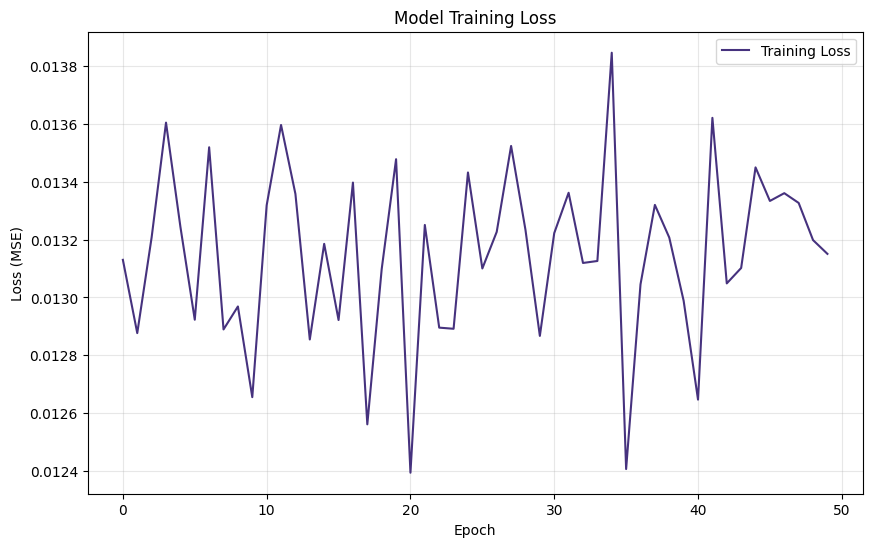


Trained model saved as 'lstm_forest_prediction_model.h5'
Saved scalers for 489 regions to 'model_scalers/'

--- Training Output Files ---
- lstm_forest_prediction_model.h5 (Trained LSTM model)
- model_scalers/ (Directory containing regional scalers)
- plot of training loss


In [ ]:
# Check if training data is available
if X_train.shape[0] == 0:
    print("\nTraining data is empty. Cannot train the model.")
else:
    # Define hyperparameters for training
    epochs = 50
    batch_size = 5

    print(f"\n--- Starting Model Training ---")
    print(f"Total samples for training: {X_train.shape[0]:,}")
    print(f"Epochs: {epochs}")
    print(f"Batch Size: {batch_size}")

    # Train the model
    # You might want to use a validation split here if you have enough data
    history = model.fit(
        X_train,
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        verbose=1 # Set to 2 for less verbose output per epoch
        # validation_split=0.2 # Example validation split
    )

    print("\n--- Model Training Complete ---")

    # Optional: Plot training history (loss)
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    # if 'val_loss' in history.history:
    #     plt.plot(history.history['val_loss'], label='Validation Loss') # Example validation loss
    plt.title('Model Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # Save the trained model
    model_filename = 'lstm_forest_prediction_model.h5'
    model.save(model_filename)
    print(f"\nTrained model saved as '{model_filename}'")

    # Save the scalers (feature_scaler and target_scaler) for prediction
    # We trained a single model on concatenated data.
    # For regional prediction, we'll need the *regional* scalers.
    # We stored these in regional_preprocessing_data. Let's save them.
    scalers_dir = 'model_scalers'
    os.makedirs(scalers_dir, exist_ok=True)

    # Save each region's scalers
    saved_scaler_count = 0
    for region_id, data in regional_preprocessing_data.items():
        if 'feature_scaler' in data and 'target_scaler' in data:
            feature_scaler_filename = os.path.join(scalers_dir, f'feature_scaler_{region_id}.pkl')
            target_scaler_filename = os.path.join(scalers_dir, f'target_scaler_{region_id}.pkl')
            joblib.dump(data['feature_scaler'], feature_scaler_filename)
            joblib.dump(data['target_scaler'], target_scaler_filename)
            saved_scaler_count += 1

    print(f"Saved scalers for {saved_scaler_count} regions to '{scalers_dir}/'")

    # Summary of saved files
    print("\n--- Training Output Files ---")
    print(f"- {model_filename} (Trained LSTM model)")
    print(f"- {scalers_dir}/ (Directory containing regional scalers)")
    print(f"- plot of training loss")

